In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
plt.style.use("default")


In [29]:
enrol = pd.read_csv("enrolment_state_metrics.csv")
demo  = pd.read_csv("demographic_state_metrics.csv")
bio   = pd.read_csv("biometric_state_metrics.csv")

In [30]:
def clean_dataset(df):
    import re

    # Function to standardize state names
    def clean_state(x):
        x = str(x).lower()
        x = re.sub(r'[^a-z\s]', ' ', x)
        x = re.sub(r'\s+', ' ', x).strip()
        return x

    # Apply cleaning
    df['states'] = df['state_clean'].apply(clean_state)

    # Correct common known variants
    state_map = {
        # Legacy / alternate spellings
        'orissa': 'Odisha',
        'pondicherry': 'Puducherry',
        'uttaranchal': 'Uttarakhand',
        'tamilnadu': 'Tamil Nadu',

        # West Bengal variants (important)
        'west bengli': 'West Bengal',
        'west bangal': 'West Bengal',
        'westbengal': 'West Bengal',
        'west bengal': 'West Bengal',
        'Westbengal' : 'West Bengal',
        'West Bangal' : 'West Bengal',


        'andaman and Nicobar Islands' : 'Andaman and Nicobar Islands',
        'andaman & Nicobar Islands' : 'Andaman and Nicobar Islands',

        'Dadra and Nagar Haveli' : 'Dadra and Nagar Haveli and Daman and Diu',
        'Dadra and Nagar Haveli and Daman and Diu' : 'Dadra and Nagar Haveli and Daman and Diu',
        'Daman and Diu' : 'Dadra and Nagar Haveli and Daman and Diu',

        'Daman & Diu' : 'Dadra and Nagar Haveli and Daman and Diu',
        'Dadra & Nagar Haveli' : 'Dadra and Nagar Haveli and Daman and Diu',

        'The Dadra and Nagar Haveli and Daman and Diu	' : 'Dadra and Nagar Haveli and Daman and Diu',


    }

    df['states'] = df['states'].replace(state_map)
    df['states'] = df['states'].str.title()

    # Remove invalid numeric state entries
    df = df[~df['states'].str.isnumeric()]
    df.drop(columns = ['state_clean'], inplace = True)
    return df


In [31]:
enrol_df = clean_dataset(enrol)
demo_df  = clean_dataset(demo)
bio_df   = clean_dataset(bio)

In [32]:
enrol_df.head(), demo_df.head(), bio_df.head()


(   avg_adult_late_ratio                                    states
 0              0.954545                                       Nan
 1              0.272437                                 Meghalaya
 2              0.104526  Dadra And Nagar Haveli And Daman And Diu
 3              0.083563                                  Nagaland
 4              0.073174                                       Goa,
    avg_updates_per_record  adult_update_ratio         states
 0              136.910942            0.901282          Delhi
 1               56.133740            0.893262   Chhattisgarh
 2               50.880808            0.893053  Uttar Pradesh
 3               49.316745            0.914286          Bihar
 4               41.370421            0.814256        Manipur,
    avg_bio_updates_per_record  adult_bio_ratio                  states
 0                  140.875041         0.557407                   Delhi
 1                   84.528696         0.548443          Madhya Pradesh
 2      

In [33]:
# Merge enrolment + demographic
df_lifecycle = enrol_df.merge(
    demo_df,
    on="states",
    how="inner"
)

# Merge biometric
df_lifecycle = df_lifecycle.merge(
    bio_df,
    on="states",
    how="inner"
)

df_lifecycle.head()

,avg_adult_late_ratio,states,avg_updates_per_record,adult_update_ratio,avg_bio_updates_per_record,adult_bio_ratio
0,0.272437,Meghalaya,16.292747,0.892639,20.973193,0.470340
1,0.104526,Dadra And Nagar Haveli And Daman And Diu,7.137405,0.915447,11.303571,0.701991
2,0.083563,Nagaland,9.117968,0.878990,28.644276,0.631880
3,0.073174,Goa,5.931431,0.930311,12.600774,0.454101
4,0.052303,Assam,16.115129,0.921025,20.626787,0.408121


Lifecycle Alignment Scatter Plot

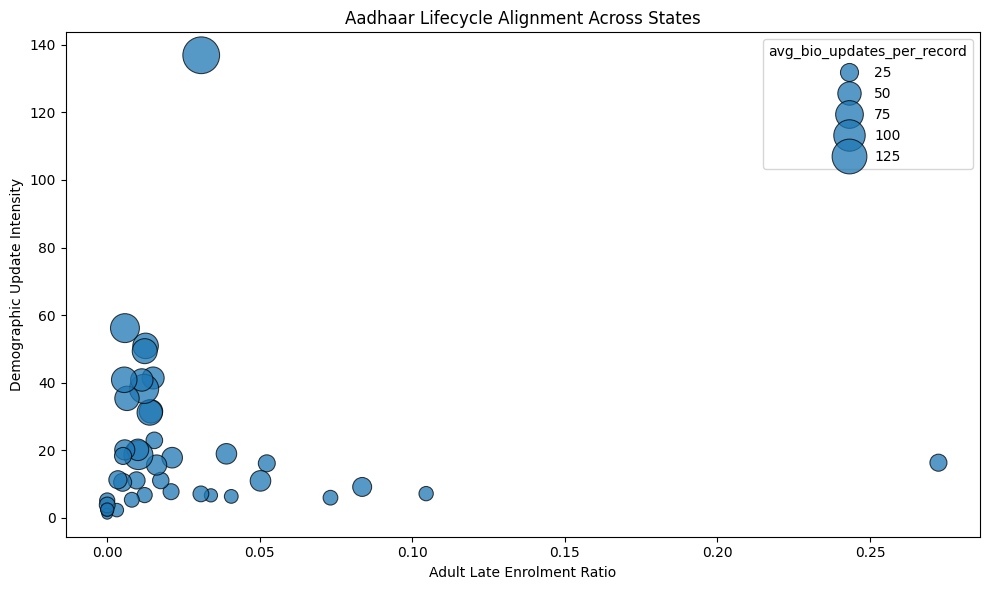

In [34]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df_lifecycle,
    x="avg_adult_late_ratio",
    y="avg_updates_per_record",
    size="avg_bio_updates_per_record",
    sizes=(60, 700),
    alpha=0.75,
    edgecolor="black"
)

plt.xlabel("Adult Late Enrolment Ratio")
plt.ylabel("Demographic Update Intensity")
plt.title("Aadhaar Lifecycle Alignment Across States")

plt.tight_layout()
plt.show()
#trivariate analysis

Enrolment → Demographic → Biometric Stress Cascade(Aadhaar interaction is episodic and reactive, not smooth.)

In [35]:
#  Enrolment Time Series
enrol_files = [
    "api_data_aadhar_enrolment_0_500000.csv",
    "api_data_aadhar_enrolment_500000_1000000.csv",
    "api_data_aadhar_enrolment_1000000_1006029.csv"
]

enrol_df = pd.concat([pd.read_csv(f) for f in enrol_files])

enrol_df['date'] = pd.to_datetime(
    enrol_df['date'], format='mixed', dayfirst=True, errors='coerce'
)

enrol_df['state_clean'] = enrol_df['state'].str.lower().str.strip().str.title()
enrol_df.drop(columns = ['state'], inplace = True)

enrol_df = clean_dataset(enrol_df)

enrol_df['total_updates'] = (
    enrol_df['age_5_17'] +
    enrol_df['age_0_5']+
    enrol_df['age_18_greater']
)
example_state = "Delhi"
enrol_ts = (
    enrol_df[enrol_df['states'] == example_state]
    .groupby('date')['total_updates']
    .sum()
    .reset_index()
)

In [36]:
# Demographic Time Series
demo_files = [
    "api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic_2000000_2071700.csv"
]

demo_df = pd.concat([pd.read_csv(f) for f in demo_files])

demo_df['date'] = pd.to_datetime(
    demo_df['date'], format='mixed', dayfirst=True, errors='coerce'
)

demo_df['state_clean'] = demo_df['state'].str.lower().str.strip().str.title()
demo_df.drop(columns = ['state'], inplace = True)

demo_df = clean_dataset(demo_df)

demo_df['total_updates'] = (
    demo_df['demo_age_5_17'] +
    demo_df['demo_age_17_']
)

demo_ts = (
    demo_df[demo_df['states'] == example_state]
    .groupby('date')['total_updates']
    .sum()
    .reset_index()
)

In [37]:
print('Unique states in Enrolment data:', enrol_df['states'].unique())
print('Unique states in Demographic data:', demo_df['states'].unique())
print('Unique states in Biometric data:', bio_df['states'].unique())

Unique states in Enrolment data: ['Meghalaya' 'Karnataka' 'Uttar Pradesh' 'Bihar' 'Maharashtra' 'Haryana'
 'Rajasthan' 'Punjab' 'Delhi' 'Madhya Pradesh' 'West Bengal' 'Assam'
 'Uttarakhand' 'Gujarat' 'Andhra Pradesh' 'Tamil Nadu' 'Chhattisgarh'
 'Jharkhand' 'Nagaland' 'Manipur' 'Telangana' 'Tripura' 'Mizoram'
 'Jammu And Kashmir' 'Chandigarh' 'Sikkim' 'Odisha' 'Kerala'
 'The Dadra And Nagar Haveli And Daman And Diu' 'Arunachal Pradesh'
 'Himachal Pradesh' 'Goa' 'Dadra And Nagar Haveli And Daman And Diu'
 'Ladakh' 'Andaman And Nicobar Islands' 'Puducherry' 'Lakshadweep'
 'Andaman Nicobar Islands' 'Dadra Nagar Haveli' 'Dadra And Nagar Haveli'
 'Daman And Diu' 'Jammu Kashmir' '' 'Daman Diu']
Unique states in Demographic data: ['Uttar Pradesh' 'Andhra Pradesh' 'Gujarat' 'Rajasthan' 'Karnataka'
 'West Bengal' 'Telangana' 'Odisha' 'Maharashtra' 'Kerala' 'Bihar'
 'Tamil Nadu' 'Madhya Pradesh' 'Assam' 'Tripura' 'Arunachal Pradesh'
 'Punjab' 'Jharkhand' 'Delhi' 'Chandigarh' 'Chhattisgarh'
 'Jam

In [38]:
# Biometric Time Series
bio_files = [
    "api_data_aadhar_biometric_0_500000.csv",
    "api_data_aadhar_biometric_500000_1000000.csv",
    "api_data_aadhar_biometric_1000000_1500000.csv",
    "api_data_aadhar_biometric_1500000_1861108.csv"
]

bio_df = pd.concat([pd.read_csv(f) for f in bio_files])

bio_df['date'] = pd.to_datetime(
    bio_df['date'], format='mixed', dayfirst=True, errors='coerce'
)

bio_df['state_clean'] = bio_df['state'].str.lower().str.strip().str.title()
bio_df.drop(columns = ['state'], inplace = True)

bio_df = clean_dataset(bio_df)

bio_df['total_bio_updates'] = (
    bio_df['bio_age_5_17'] +
    bio_df['bio_age_17_']
)

bio_ts = (
    bio_df[bio_df['states'] == example_state]
    .groupby('date')['total_bio_updates']
    .sum()
    .reset_index()
)


In [39]:
# Example state for cascade analysis
example_state = "Delhi"

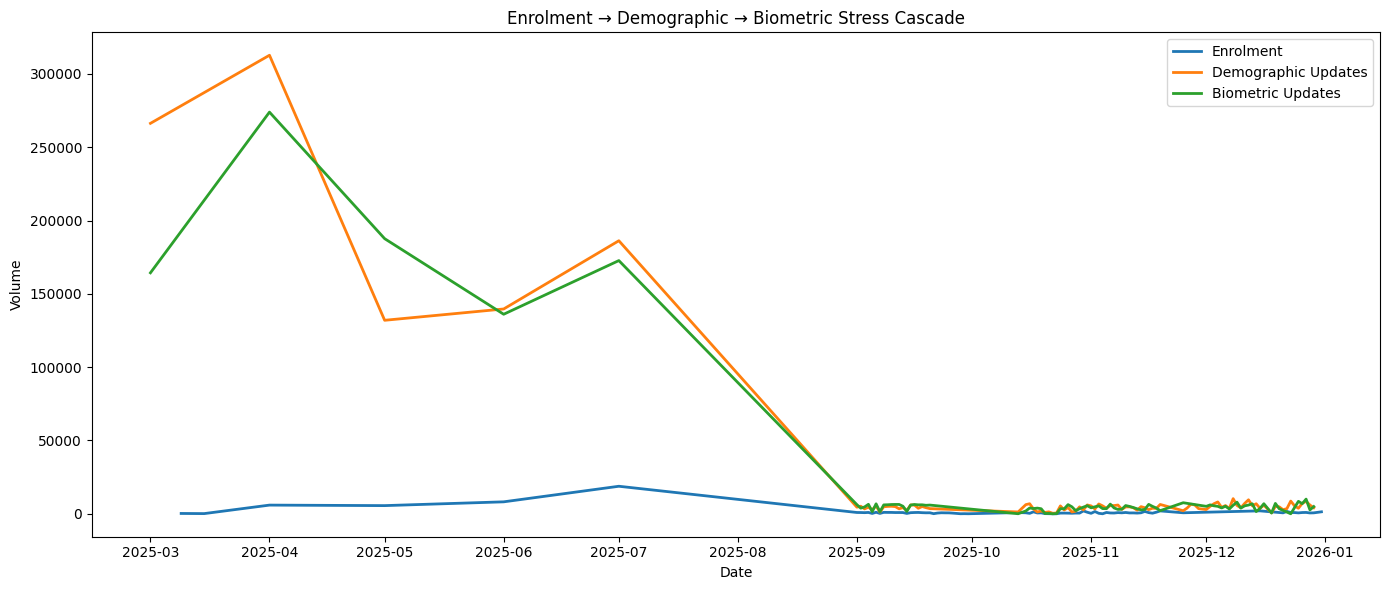

In [40]:
plt.figure(figsize=(14,6))

plt.plot(
    enrol_ts['date'],
    enrol_ts['total_updates'],
    label="Enrolment",
    linewidth=2
)

plt.plot(
    demo_ts['date'],
    demo_ts['total_updates'],
    label="Demographic Updates",
    linewidth=2
)

plt.plot(
    bio_ts['date'],
    bio_ts['total_bio_updates'],
    label="Biometric Updates",
    linewidth=2
)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Enrolment → Demographic → Biometric Stress Cascade")

plt.tight_layout()
plt.show()


Persistence of Access Inequality Across Aadhaar Lifecycle(Exclusion does not end at enrolment.)

In [41]:
# Example values (replace with computed shares from your notebooks)
access_inequality = pd.DataFrame({
    "Stage": ["Enrolment", "Demographic Updates", "Biometric Updates"],
    "Top_10pct_Pincode_Share": [0.52, 0.49, 0.55]
})


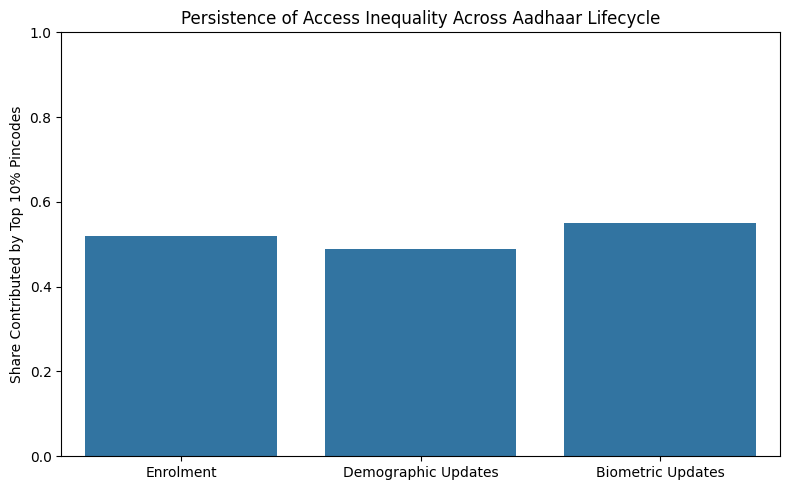

In [42]:
plt.figure(figsize=(8,5))

sns.barplot(
    data=access_inequality,
    x="Stage",
    y="Top_10pct_Pincode_Share"
)

plt.ylabel("Share Contributed by Top 10% Pincodes")
plt.xlabel("")
plt.title("Persistence of Access Inequality Across Aadhaar Lifecycle")

plt.ylim(0,1)
plt.tight_layout()
plt.show()


Integrated Lifecycle Insights:

• States with delayed Aadhaar entry also exhibit higher demographic update
  intensity and biometric refresh activity, indicating Aadhaar’s role as a
  migration- and life-event-driven identity system.

• Temporal alignment of enrolment, demographic, and biometric spikes reveals
  that Aadhaar interaction is episodic and reactive rather than uniformly
  distributed over time.

• Spatial concentration of enrolments persists across demographic and biometric
  updates, demonstrating that access inequality continues even after initial
  inclusion.
